## Predict a car's market

For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. Read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile).

In [1]:
import pandas as pd
import numpy as np

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [3]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
# numeric columns
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

### Data Cleaning

In [5]:
numeric_cars = numeric_cars.replace('?', np.nan)

In [6]:
numeric_cars = numeric_cars.astype('float')

In [7]:
# dealing with missing values
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [8]:
numeric_cars['normalized-losses'].shape

(205,)

In [9]:
# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [10]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [11]:
# Confirm that there's no more missing values!
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [12]:
# Normalize the numeric ones so all values range from 0 to 1
price_col = numeric_cars['price'] # keep price as original
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

In [13]:
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


### Univariate Model

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [15]:
def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor() #instaniate
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Split dataframe into train and test
    train_df = df.iloc[0:last_train_row]
    test_df = df.iloc[last_train_row:]
    
    # Fit the model, predict and calculate rmse
    knn.fit(train_df[[train_col]],train_df[target_col])
    predictions = knn.predict(test_df[[train_col]])
    rmse = mean_squared_error(predictions, test_df[target_col])**0.5
    return rmse

In [16]:
# Use this function to train and test univariate models using the different numeric columns in the data set.
cols = numeric_cars.columns.drop('price')
rmse_results = {}

for col in cols:
    rmse = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse

In [17]:
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

horsepower            4267.730361
highway-mpg           4628.793094
city-mpg              4814.778015
curb-weight           5166.828581
width                 7110.412630
compression-rate      8096.301512
normalized-losses     8131.436882
length                8304.189346
stroke                9334.714914
peak-rpm              9759.209970
wheel-base            9969.243292
height               10839.693636
bore                 13397.091693
dtype: float64

In [18]:
# Modify the function to accept k as a parameter
def knn_train_test(train_col, target_col, df, k):
    knn = KNeighborsRegressor(n_neighbors=k) #instaniate
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Split dataframe into train and test
    train_df = df.iloc[0:last_train_row]
    test_df = df.iloc[last_train_row:]
    
    # Fit the model, predict and calculate rmse
    knn.fit(train_df[[train_col]],train_df[target_col])
    predictions = knn.predict(test_df[[train_col]])
    rmse = mean_squared_error(predictions, test_df[target_col])**0.5
    return rmse

In [19]:
rmse_results = {}
k_values = [1,3,5,7,9]

for col in cols:
    k_results = {}
    for i in k_values:
        rmse = knn_train_test(col, 'price', numeric_cars, i)
        rmse_results[col] = rmse
        k_results[i] = rmse
    rmse_results[col] = k_results

In [20]:
rmse_results

{'bore': {1: 16502.858944335483,
  3: 13895.111787987171,
  5: 13397.091693481998,
  7: 11075.156453540423,
  9: 10178.905997122287},
 'city-mpg': {1: 5347.1502616620082,
  3: 5210.2611302222185,
  5: 4814.7780148494103,
  7: 4575.9500050566039,
  9: 4770.3441789226026},
 'compression-rate': {1: 8085.6051421555012,
  3: 8137.9697256948321,
  5: 8096.3015121133867,
  7: 7896.6928707790858,
  9: 7823.115528549677},
 'curb-weight': {1: 6566.7491754043158,
  3: 5635.1847483924475,
  5: 5166.8285806461754,
  7: 5239.6312507047951,
  9: 5244.5555635847895},
 'height': {1: 13032.276289928392,
  3: 11411.019683044135,
  5: 10839.693635873846,
  7: 10041.327943738908,
  9: 9313.3309652812659},
 'highway-mpg': {1: 5188.3334702021421,
  3: 4655.0814815167259,
  5: 4628.7930938146865,
  7: 4112.3878029567513,
  9: 4029.9622707968324},
 'horsepower': {1: 7027.6069712651306,
  3: 5400.9297932358968,
  5: 4267.7303610297877,
  7: 3821.3765663687641,
  9: 3461.132024333479},
 'length': {1: 10053.57906

### Multivariate Model

In [22]:
# Modify the function to accept k as a parameter
def knn_train_test(train_col, target_col, df, k=5):
    knn = KNeighborsRegressor(n_neighbors=k) #instaniate
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Split dataframe into train and test
    train_df = df.iloc[0:last_train_row]
    test_df = df.iloc[last_train_row:]
    
    # Fit the model, predict and calculate rmse
    knn.fit(train_df[train_col],train_df[target_col])
    predictions = knn.predict(test_df[train_col])
    rmse = mean_squared_error(predictions, test_df[target_col])**0.5
    return rmse

In [31]:
k_rmse_results = {}

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars, 5)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars, 5)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars, 5)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars, 5)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars, 5)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

{'five best features': 4472.2804078385598,
 'four best features': 4700.6472093249722,
 'six best features': 5276.4068591201612,
 'three best features': 4667.0583479710576,
 'two best features': 4101.8359934580176}

In [32]:
# For the top 3 models in the last step, vary the hyperparameter value from 1 to 25 and plot the resulting RMSE values.
two_best_features_results = {}
five_best_features_results = {}
three_best_features_results = {}
for k in range(1,26):
    two_best_rmse = knn_train_test(two_best_features, 'price', numeric_cars, k)
    three_best_rmse = knn_train_test(three_best_features, 'price', numeric_cars, k)
    five_best_rmse = knn_train_test(five_best_features, 'price', numeric_cars, k)
    two_best_features_results[k] = two_best_rmse
    three_best_features_results[k] = three_best_rmse
    five_best_features_results[k]  = five_best_rmse

In [35]:
# Combined:
k_rmse_results = {}
k_rmse_results['Two Best Features'] = two_best_features_results
k_rmse_results['Three Best Features'] = three_best_features_results
k_rmse_results['Five Best Features'] = five_best_features_results

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

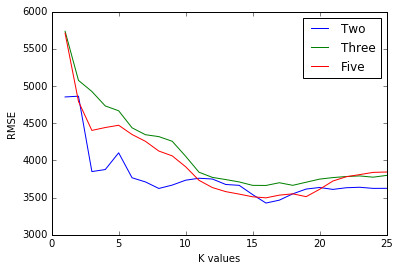

In [59]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y)
    plt.xlabel('K values')
    plt.ylabel('RMSE')
plt.legend(['Two','Three','Five'])
plt.show()

### Next Steps:
- Modify the knn_train_test() function to use k-fold cross validation instead of test/train validation.
- Modify the knn_train_test() function to perform the data cleaning as well.